# DBP(이완기혈압) 

### X변수(기본)
- sex : 1(남자), 2(여자)
- age : 20세 부터 5세 단위
- ht : 5cm단위
- wt : 5kg 단위
- waist : 허리둘레 cm
- bmi 
- absi : 체형지수 => 허리둘레 / (BMI * 2/3) * (ht * 1/2)
- smoking : 1(피우지 않음), 2(피웠다끊음), 3(피우고있음)
- alcohol : 0(마시지않음), 1(마심)

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 한글 지원
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf" 
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 상관계수
from scipy import stats

# model
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz
import xgboost
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor

## 1. 데이터 불러오기

In [2]:
df = pd.read_csv('C:/Users/sja95/OneDrive/바탕 화면/dataset/건강검진2017.csv', encoding = 'euc-KR')

df.columns

Index(['기준년도', '가입자일련번호', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)',
       '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태',
       '음주여부', '구강검진수검여부', '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석',
       '데이터공개일자'],
      dtype='object')

In [3]:
df = df[['성별코드','연령대코드(5세단위)','신장(5Cm단위)','체중(5Kg단위)','허리둘레','흡연상태','음주여부','이완기혈압']]
df.columns = ['sex','age','ht','wt','waist','smoking','alcohol','dbp']

## 2. 데이터 전처리

### 1) 결측값 제거

In [4]:
df = df.dropna(axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999090 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      999090 non-null  int64  
 1   age      999090 non-null  int64  
 2   ht       999090 non-null  int64  
 3   wt       999090 non-null  int64  
 4   waist    999090 non-null  float64
 5   smoking  999090 non-null  float64
 6   alcohol  999090 non-null  object 
 7   dbp      999090 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 68.6+ MB


### 2) bmi column 생성

In [5]:
df['bmi'] = df['wt'] / ((df['ht']/100)**2)

### 3) absi columns 생성

- 허리둘레 / (BMI * 2/3) * (ht * 1/2)

In [6]:
df['absi'] = (df['waist']*0.393701) / ((df['bmi']**0.6666) * ((df['ht']/100)** 0.5))
df = df.round(decimals = 2)

df.head(10)

,sex,age,ht,wt,waist,smoking,alcohol,dbp,bmi,absi
0,1,8,170,75,90.0,1.0,Y,80.0,25.95,3.10
1,1,7,180,80,89.0,3.0,N,82.0,24.69,3.08
2,1,9,165,75,91.0,1.0,N,70.0,27.55,3.06
3,1,11,175,80,91.0,1.0,N,87.0,26.12,3.08
4,1,11,165,60,80.0,1.0,N,82.0,22.04,3.12
5,1,11,165,55,75.0,3.0,Y,92.0,20.20,3.10
6,2,10,150,55,69.0,1.0,N,58.0,24.44,2.63
7,1,8,175,65,84.2,3.0,Y,80.0,21.22,3.27
8,1,12,170,75,84.0,1.0,Y,85.0,25.95,2.89
9,1,9,175,75,82.0,2.0,Y,105.0,24.49,2.89


### 3) alcohol : str -> float형으로 변환

In [7]:
df.loc[(df.alcohol=='Y'),'alcohol'] = 1.0
df.loc[(df.alcohol=='N'), 'alcohol'] = 0.0

df['alcohol'] = df.alcohol.astype(float)

In [8]:
df.info()

df_o = df.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999090 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      999090 non-null  int64  
 1   age      999090 non-null  int64  
 2   ht       999090 non-null  int64  
 3   wt       999090 non-null  int64  
 4   waist    999090 non-null  float64
 5   smoking  999090 non-null  float64
 6   alcohol  999090 non-null  float64
 7   dbp      999090 non-null  float64
 8   bmi      999090 non-null  float64
 9   absi     999090 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 83.8 MB


### 4) 이상값 제거

- IQR = Q3 - Q1 
- Q1 -3 * IQR => lower
- Q3 + 3 * IQR => upper 로 설정
- lower보다 작거나 upper보다 큰 값을 이상값으로 간주하고 제거

- 변수마다 lower, upper 값을 확인하고 제거하는 과정을 거치면 다른 변수 lower/upper값에 영향을 줄 수 있음
- 따라서, 변수 각각의 lower, upper 값을 미리 모두 확인 후 각 값에 맞춰 범위 외의 값을 제거해줌.

#### (1) lower / upper 값 구하기

In [9]:
columns = ['bmi','waist', 'absi', 'dbp']

for column in columns:
    
    print('=======', column, '=======')
    
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    IQR = q75 - q25
    
    lower = q25 - IQR*3
    upper = q75 + IQR*3
    
    print('lower :', lower)
    print('upper :', upper, '\n')
    


======= bmi =======
lower : 8.070000000000004
upper : 39.36 

======= waist =======
lower : 32.999999999999986
upper : 128.9 

======= absi =======
lower : 2.119999999999999
upper : 3.940000000000001 

======= dbp =======
lower : 34.0
upper : 118.0 



#### (2) 이상값 제거 

In [10]:
# bmi
df.drop(df.loc[(df['bmi']>39.36)|(df['bmi']<8.07)].index, inplace = True)

# waist
df.drop(df.loc[(df['waist']>128.9)|(df['waist']<55.0)].index, inplace = True)

# absi
df.drop(df.loc[(df['absi']>3.94)|(df['absi']<2.12)].index, inplace = True)

# sbp
df.drop(df.loc[(df['dbp']>118.0)|(df['dbp']<34.0)].index, inplace = True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996821 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      996821 non-null  int64  
 1   age      996821 non-null  int64  
 2   ht       996821 non-null  int64  
 3   wt       996821 non-null  int64  
 4   waist    996821 non-null  float64
 5   smoking  996821 non-null  float64
 6   alcohol  996821 non-null  float64
 7   dbp      996821 non-null  float64
 8   bmi      996821 non-null  float64
 9   absi     996821 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 83.7 MB


# 3. Modeling 

## 1-1) DecisionTreeRegression_원본

In [157]:
## 1. split

X = df_o[['sex','age','bmi','ht','wt','waist','absi','smoking','alcohol']]
y = df_o['dbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((699363, 9), (299727, 9), (699363,), (299727,))

rmse :  9.234197142272775


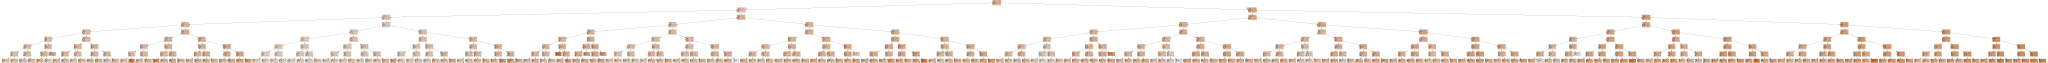

In [158]:
## 2. fit 

dt = DecisionTreeRegressor(random_state = 2045, max_depth = 8  ,min_samples_split = 128)
dt.fit(X_train, y_train)

## 3. Predict

y_hat = dt.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

## 5. Visualization

graphviz.Source(export_graphviz(dt, filled = True))


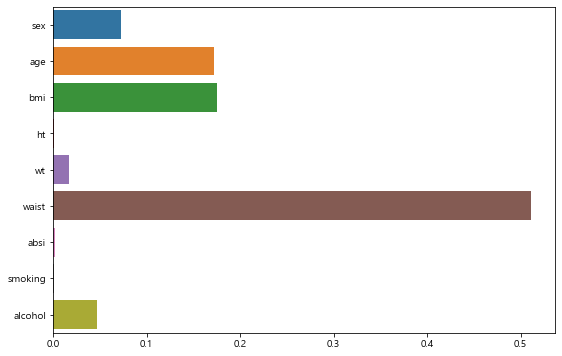

In [159]:
## 6. Feature Importance

plt.figure(figsize = (9,6))
sns.barplot(dt.feature_importances_,
           X_train.columns)
plt.show()

In [22]:
## 1. split

X = df[['sex','age','absi','bmi','waist','smoking','alcohol']]
y = df['dbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((697774, 7), (299047, 7), (697774,), (299047,))

rmse :  9.118812525126222


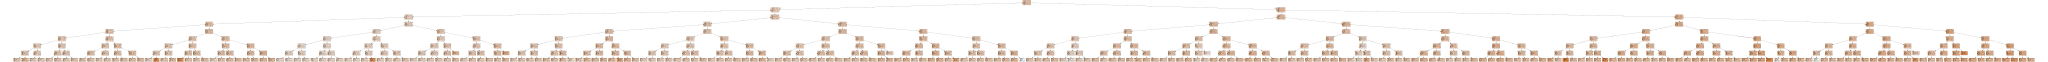

In [23]:
## 2. fit 

dt = DecisionTreeRegressor(random_state = 2045, max_depth = 8  ,min_samples_split = 128)
dt.fit(X_train, y_train)

## 3. Predict

y_hat = dt.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

## 5. Visualization

graphviz.Source(export_graphviz(dt, filled = True))


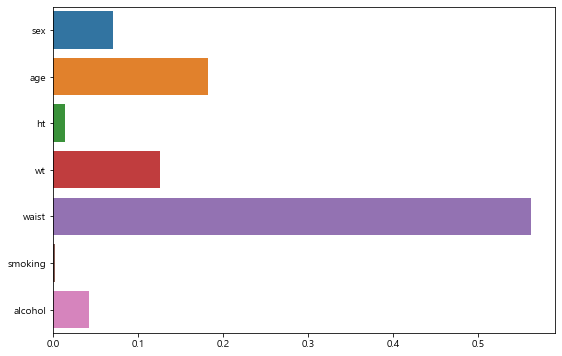

In [19]:
## 6. Feature Importance

plt.figure(figsize = (9,6))
sns.barplot(dt.feature_importances_,
           X_train.columns)
plt.show()

- max_depth / min_sample_split 값을 변경해가면서 모델 생성 결과 max_depth:8 일 때 rmse가 13.16으로 가장 적었음
- (min_sample_splie값은 변경해도 변화없음)

- 표준화 및 정규화된 X_train 사용해도 모델 성능에 변화 없음

## 2-1) RandomForest_원본

In [24]:
## 1. split

X = df[['sex','age','bmi','ht','wt','waist','absi','smoking','alcohol']]
y = df['dbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((697774, 9), (299047, 9), (697774,), (299047,))

In [25]:
%%time

## 2. fit 

rf = RandomForestRegressor(random_state = 2045, max_depth = 10  ,max_features = 4, n_jobs = -1, n_estimators = 100)
rf.fit(X_train, y_train)

## 3. Predict

y_hat = rf.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  9.095928633234626
Wall time: 11.8 s


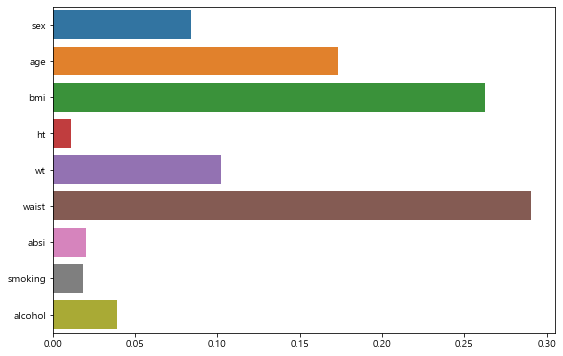

In [26]:
## 6. Feature Importance

plt.figure(figsize = (9,6))
sns.barplot(rf.feature_importances_,
           X_train.columns)
plt.show()

## 3-1) GradientBoostingRegressor_원본

rmse :  9.087827014445827


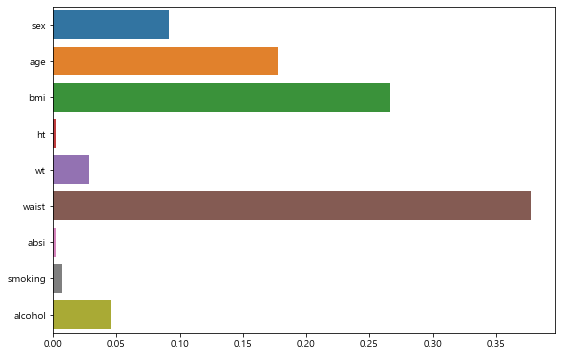

Wall time: 8min 16s


In [27]:
%%time

## 2. fit 

gb = GradientBoostingRegressor(random_state = 2045, n_estimators = 1000, learning_rate = 0.03)
gb.fit(X_train, y_train)

## 3. Predict

y_hat = gb.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

## 6. Feature Importance

plt.figure(figsize = (9,6))
sns.barplot(gb.feature_importances_,
           X_train.columns)
plt.show()


## 4-1) XGBRegressor_gbtree

rmse :  9.098494684299132
Wall time: 4min


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

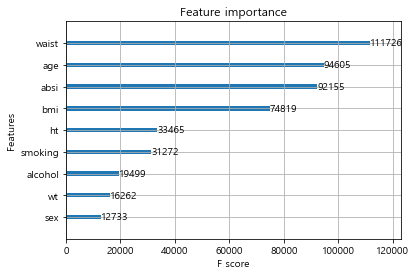

In [28]:
%%time

## 2. fit 

xgb = XGBRegressor(random_state = 2045, 
                    n_estimators = 1000, 
                    learning_rate = 0.01,
                   max_depth = 10)
xgb.fit(X_train, y_train)

## 3. Predict

y_hat = xgb.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

## 6. Feature Importance

xgboost.plot_importance(xgb)


## 4-2) XGBRegressor_gblinear

In [29]:
## 1. split

X = df[['sex','age','ht','wt','waist','bmi','absi','smoking','alcohol']]
y = df['dbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((697774, 9), (299047, 9), (697774,), (299047,))

In [30]:
%%time

## 2. fit 

xgb = XGBRegressor(random_state = 2045,
                   booster = 'gblinear',
                    n_estimators = 2000, 
                    learning_rate = 0.2)
xgb.fit(X_train, y_train)

## 3. Predict

y_hat = xgb.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  9.191545651675767
Wall time: 30.4 s


<AxesSubplot:>

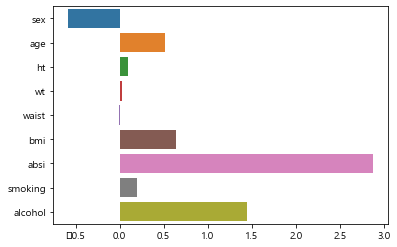

In [31]:
coef = pd.Series(xgb.coef_, index = X_train.columns)
sns.barplot(x = coef.values, y = coef.index)

In [34]:
## 1. split

X = df[['sex','age','bmi','ht','wt','absi','waist','smoking','alcohol']]
y = df['dbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((697774, 9), (299047, 9), (697774,), (299047,))

In [33]:
%%time

## 2. fit 

xgb = XGBRegressor(random_state = 2045,
                   booster = 'gblinear',
                    n_estimators = 2000, 
                    learning_rate = 0.2)
xgb.fit(X_train, y_train)

## 3. Predict

y_hat = xgb.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  9.194985760696827
Wall time: 29.8 s


<AxesSubplot:>

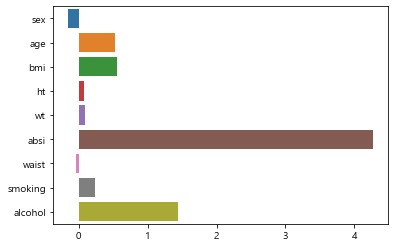

In [173]:
coef = pd.Series(xgb.coef_, index = X_train.columns)
sns.barplot(x = coef.values, y = coef.index)

## 5-1) LGBRegressor

In [48]:
## 1. split

X = df[['sex','age','wt','bmi','absi','ht','smoking','alcohol']]
y = df['dbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((697774, 8), (299047, 8), (697774,), (299047,))

rmse :  9.088586414802377


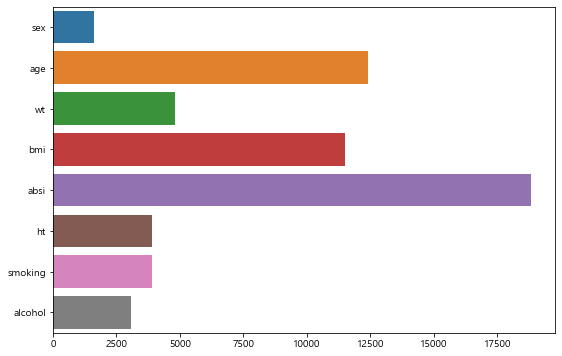

Wall time: 21.5 s


In [49]:
%%time

## 2. fit 

lgb = LGBMRegressor(random_state = 2045,
                    n_estimators = 2000, 
                    learning_rate = 0.01,
                  max_depth = 12)
lgb.fit(X_train, y_train)

## 3. Predict

y_hat = lgb.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

## 6. Feature Importance

plt.figure(figsize = (9,6))
sns.barplot(lgb.feature_importances_,
           X_train.columns)
plt.show()


## 6) MLPregressor

In [50]:
## 1. split

X = df[['sex','age','bmi','ht','wt','waist','absi','smoking','alcohol']]
y = df['dbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((697774, 9), (299047, 9), (697774,), (299047,))

In [51]:
%%time 

## 2. model define & fit

mlp = MLPRegressor(hidden_layer_sizes = (64,64), activation = 'relu', random_state = 2045,
                  max_iter = 2000)
mlp.fit(X_train, y_train)

## 3. predicition

y_hat = mlp.predict(X_test)

## 4. RMSE, R2 score

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)
print('r2 score : ', r2_score(y_test, y_hat))

rmse :  9.128444585857526
r2 score :  0.128259639696373
Wall time: 9min 44s


In [177]:
mlp.coefs_

[array([[-1.71449625e-002, -4.70669360e-315,  4.64051200e-315,
         -2.62643718e-315,  3.97713584e-315, -4.57210092e-315,
         -2.79595598e-315, -7.46768811e-317, -9.85643271e-316,
         -1.00576959e-315, -3.12746854e-315,  3.56150822e-001,
         -1.83178926e+000, -1.80785157e+000, -1.10959777e-315,
         -1.39476380e-315, -9.54567217e-003, -1.09515725e-315,
          2.50345062e-315,  1.16630228e-001,  4.10334098e-316,
         -3.26070185e-315,  3.75144429e-315,  3.62548964e-315,
         -2.78716480e-315,  3.80485791e-315, -2.76744043e+000,
         -1.73917008e+000, -2.91464151e-315,  3.78122318e+000,
          1.65885576e+000, -2.17672615e-315,  6.65792800e-316,
          4.41274451e-315,  3.52136959e-001, -1.31466872e+000,
         -2.61956605e-315, -2.94100456e-315, -4.81348706e+000,
         -2.80735948e-315, -2.83728457e-315, -7.09771406e-001,
          3.27781455e-316, -1.12491273e-315, -3.00957052e-315,
          1.41650786e-315, -4.66340462e-315, -7.7303266